In [45]:
import numpy as np

from numga.algebra.algebra import Algebra
from numga.backend.numpy.context import NumpyContext as Context
from numga.examples.physics.core import Body
context = Context(Algebra('x+y+z+np+nm-'), dtype=np.float64)
context.__dir__()
for i in range(32):
    print(context.algebra.subspace.blade(i))
context.algebra.subspace.__dir__()

is_scalar: 1
in_vector: x
in_vector: y
in_bivector: xy
in_vector: z
in_bivector: xz
in_bivector: yz
in_antibivector: xyz
in_vector: np
in_bivector: xnp
in_bivector: ynp
in_antibivector: xynp
in_bivector: znp
in_antibivector: xznp
in_antibivector: yznp
in_antivector: xyznp
in_vector: nm
in_bivector: xnm
in_bivector: ynm
in_antibivector: xynm
in_bivector: znm
in_antibivector: xznm
in_antibivector: yznm
in_antivector: xyznm
in_bivector: npnm
in_antibivector: xnpnm
in_antibivector: ynpnm
in_antivector: xynpnm
in_antibivector: znpnm
in_antivector: xznpnm
in_antivector: yznpnm
is_pseudoscalar: xyznpnm


['flyweight_pool',
 'algebra',
 'order',
 'grades',
 'blades_by_grade',
 '__module__',
 '__doc__',
 '__init__',
 'order_blades',
 '__getattr__',
 'basis',
 'from_blades',
 'from_grades',
 'from_bit_str',
 'k_vector',
 'blade',
 'scalar',
 'vector',
 'bivector',
 'trivector',
 'quadvector',
 'pseudoscalar',
 'antiscalar',
 'antivector',
 'antibivector',
 'antitrivector',
 'antiquadvector',
 'scalar_pseudoscalar',
 'nonscalar',
 'multivector',
 'full',
 'empty',
 'even_grade',
 'motor',
 'translator',
 'rotor',
 'self_involute',
 'odd_grade',
 'k_reflection',
 'reflection',
 'bireflection',
 'trireflection',
 'quadreflection',
 'self_reverse',
 'mod4',
 'degenerate',
 'scalar_degenerate',
 'nondegenerate',
 'factory_construct',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook

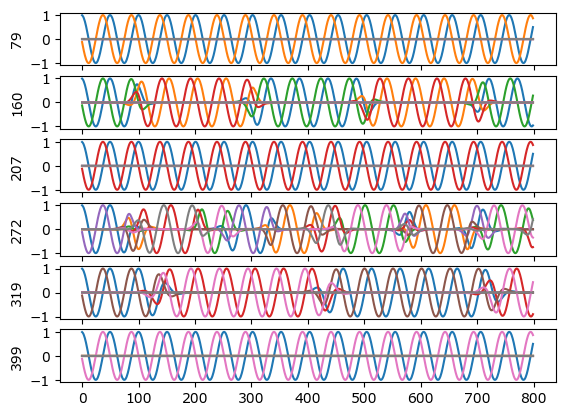

In [1]:
"""Test the tennis racket theorem, or medial axis theorem."""

import numpy as np

from numga.algebra.algebra import Algebra
from numga.backend.numpy.context import NumpyContext as Context
from numga.examples.physics.core import Body

dt = 1 / 4
runtime = 200
p=4
# works for p=2,3,4,5
# p>3 is fascinating; some medial axes become seemingly chaotic
# but stranger still, some medial axes actually stabilize?
context = Context(Algebra.from_pqr(p, 0, 0), dtype=np.float64)

def make_n_cube(N):
	b = ((np.arange(2 ** N)[:, None] & (1 << np.arange(N))) > 0)
	return (2 * b - 1)
def make_n_rect(N):
	return make_n_cube(N) * (np.arange(N) + 1)
def make_point_cloud():
	points = make_n_rect(context.algebra.description.n_dimensions)
	return context.multivector.vector(points).dual()

# create a point cloud with distinct moments of inertia
points = make_point_cloud()
# set up independent identical copies of the point cloud
# equal to the number of independent spin planes
nb = len(context.subspace.bivector())
body = Body.from_point_cloud(points=points.repeat('... -> b ...', b=nb))

# set up initial conditions;
# each body gets a spin in a different plane; plus some jitter.
body.rate = body.rate + context.multivector.bivector(np.eye(nb) + np.random.normal(size=(nb, nb)) * 1e-5)
E = body.kinetic_energy()

#states = []
def timesteps(body=body,runtime=runtime,dt=dt,E=E): 
  for i in range(int(runtime / dt)):
    body = body.integrate(dt)

    if False:
		# optionally, enforce strict energy conservation
        energy_violation = body.kinetic_energy() / E
        body = body.copy(rate=body.rate / energy_violation.sqrt())

#	print(i)
#	states.append(body.motor)
    yield body.motor
states=list(timesteps())

# visualize tumbling behavior
import matplotlib.pyplot as plt
v = np.array([s.values for s in states])
fig, ax = plt.subplots(nb, squeeze=False)
for i in range(nb):
	ax[i, 0].plot(v[:, i])
	# this shows initial energy; so we can distinguish medial axes from extrema
	ax[i, 0].set_ylabel(int(E.values[i][0]))

In [21]:
"""Explore working with CGA in numga"""

import numpy as np

from numga.backend.numpy.context import NumpyContext
from numga.examples.conformal import Conformal, Conformalize


def plot_point(plt, cga, p, color='b'):
	assert p.subspace.inside.vector()
	plt.scatter(*cga.point_position(cga.normalize(p)).values.T,c=color)


def plot_circle(plt, cga, circle):
    assert circle.subspace.inside.antivector()
    circle = cga.normalize(circle.dual())
    # this is pretty elegant; center is point at infinity reflected in the circle
    center = cga.normalize(circle >> cga.ni)
    radius = circle.norm()
    
    ang = np.linspace(0, 2 * np.pi, 101, endpoint=True)
    cx, cy = np.cos(ang), np.sin(ang)
    r = radius.values
    px, py = cga.point_position(center).values.T
    if isinstance(px, float):
        plt.plot(cx * r + px, cy * r + py)
    else:
        for xx, yy, rr in zip(px, py, r):
            plt.plot(cx * rr + xx, cy * rr + yy)


def test_circle_reflect():
	# construct 2d cga
	cga = Conformalize(NumpyContext('x+y+'))

	# construct a point grid
	points = np.meshgrid(np.linspace(-1, 1, 11), np.linspace(-1, 1, 11))
	#P = cga.embed_point(np.array(points).T.reshape(-1, 2), r=0.1)
	P = cga.embed_point((1.0,0.0), r=np.array([0.5,0.6,0.7,0.8,0.9,0.99,0.999,0.9999,1]))
	# construct a circle
	# C = cga.embed_point((-1.5, -1.5), r=2).dual()
	#C = cga.embed_point((0.1, 0.2), r=2).dual()
	C = cga.embed_point((0., 0.), r=2).dual()

	Q = C >> P

	import matplotlib.pyplot as plt
	plot_circle(plt, cga, P.dual())
	plot_circle(plt, cga, Q.dual())
	plot_circle(plt, cga, C)
	plt.plot(0.,0.,'r+')
	# plot_point(plt, cga, cga.project(Q, C.dual()))
	plt.axis('equal')
	scale=400.0
	plt.xlim(-scale,scale)
	plt.ylim(-scale,scale)



def test_circle_fit():
	# construct 2d cga
	cga = Conformal(NumpyContext(Conformal.algebra('x+y+')))

	assert np.allclose(cga.ni.norm().values, 0)
	assert np.allclose(cga.no.norm().values, 0)
	assert np.allclose(((cga.N * cga.N)).values, 1)

	# create some points
	a, b, c, d = cga.embed_point((-1.5, -0.5)), cga.embed_point((1, -0.5)), cga.embed_point((0, 1.5)), cga.embed_point((0,0))

	assert np.allclose(b.inner(cga.ni).values, -1)
	assert np.allclose((b*b).values, 0)
	assert np.allclose(cga.point_position(b).values, (1, -0.5))

	# construct a circle as the wedge of three points
	C = a ^ b ^ c 
	# direct construction of a circle
	D = cga.embed_point((-1, -1), r=1).dual()
	# get intersection set of two circles
	T = C & D 
	# split them out into two points
	l, r = cga.split_points(T)

	print(D.norm_squared())


	import matplotlib.pyplot as plt

	plot_circle(plt, cga, C)
	plot_circle(plt, cga, D)

	plot_point(plt, cga, a,'b')
	plot_point(plt, cga, b,'b')
	plot_point(plt, cga, c,'b')

	plot_point(plt, cga, l,'r')
	plot_point(plt, cga, r,'r')

	plt.axis('equal')

is_scalar: <1>
[-1.]


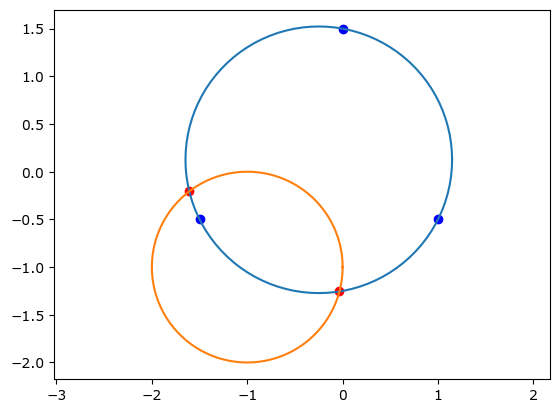

In [22]:
test_circle_fit()

/private/var/mobile/Containers/Data/Application/77881549-3FA6-4E4B-803F-D53B172FC865/Documents/myrepo/numga/multivector/multivector.py:311: RuntimeWarning: divide by zero encountered in divide
  return self.copy(values=self.values / other.values)
/private/var/mobile/Containers/Data/Application/77881549-3FA6-4E4B-803F-D53B172FC865/Documents/myrepo/numga/multivector/multivector.py:311: RuntimeWarning: invalid value encountered in divide
  return self.copy(values=self.values / other.values)


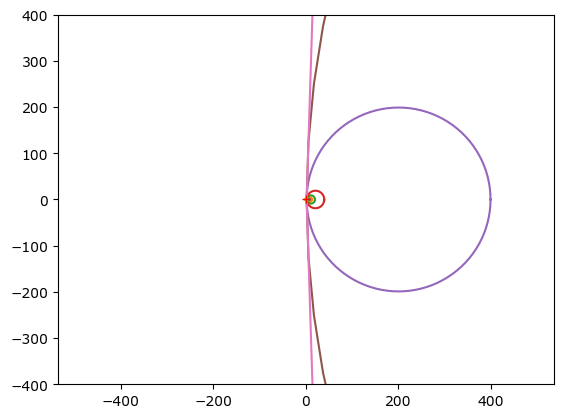

In [4]:
test_circle_reflect()

In [5]:
"""XPBD swinging rigid body chain link"""

import numpy as np

from numga.backend.numpy.context import NumpyContext as Context


# want this to work at least for 2d-3d-4d pga/elliptical; still need to add 4d elliptical rendering!
context = Context(
	# 'x+y+',
	 'x+y+z+',       # for some reason this is my favorite
	# 'x+y+w0',
	# 'x+y+z+w0',   # should really make the setup a bit more interesting here; not really showing off 3d atm
	# otype=JaxSparseOperator,
	dtype=np.float64
)

from numga.examples.physics.setup_chain import setup_bodies
bodies, constraint_sets = setup_bodies(
	context,
	# do a springy sim in 1d, otherwise no real dynamics to look at
	compliance=1e-2 if context.algebra.n_dimensions == 2 else 1e-9
)


def step(bodies, constraint_sets, dt, unroll=10):
	"""Jax specific part of main loop, to be compiled"""
	for i in range(unroll):
		bodies = bodies.integrate(dt / unroll, constraint_sets)
	return bodies


dt = 1 / 10
# runtime = 1#60    # runtime in seconds

import time


t = time.time()
mystates = []
for i in range(270): 
	bodies = step(bodies, constraint_sets, dt)
	#print(i)
	#print('energy: ', bodies.kinetic_energy().values.sum())
	if i % 5 == 0:
		mystates.append(bodies)
print('simulation time')
print(time.time() - t)
 
from numga.examples.physics.render import render
render(context, mystates)

simulation time
21.318413019180298


/private/var/mobile/Containers/Data/Application/77881549-3FA6-4E4B-803F-D53B172FC865/Documents/myrepo/numga/multivector/multivector.py:399: RuntimeWarning: invalid value encountered in sqrt
  return self.copy(values=self.values ** 0.5)
